In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
import os

DIVERSITY_UTILITY = float(os.environ.get('DIVERSITY_UTILITY'))
FRAC_ADMIT = float(os.environ.get('FRAC_ADMIT'))

In [2]:

###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)

###
## Estimate E[Y(1)|T, A]
###

df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = (df_stratum_utility['Y'] + DIVERSITY_UTILITY * df_stratum_utility['R']).round(2)
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [3]:
FRAC_ADMIT = 0.5#df[['A']].sum()/len(df)


In [4]:
FRAC_ADMIT

0.5

In [5]:
len(df)

100000

<AxesSubplot:>

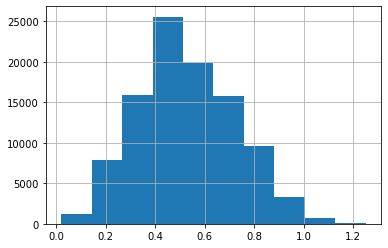

In [6]:
df['ml_outcomes'].hist()

In [7]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_minority','T_majority','Y']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_minority,T_majority,Y
99974,0,12,0.02,10,12,0
99914,0,16,0.03,10,16,0
99913,0,16,0.03,12,16,0
99650,0,17,0.06,14,17,0
99653,0,17,0.06,13,17,0
...,...,...,...,...,...,...
99940,1,94,1.21,94,107,0
99949,1,101,1.23,101,118,1
98552,1,98,1.25,98,114,1
99977,1,112,1.25,112,129,1


In [8]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [9]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [10]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [11]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [12]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,191,0,0,12,0.02,1,0.0
104,187,104,1,7,0.25,1,0.0
105,186,105,1,12,0.31,1,0.0
106,182,106,1,13,0.60,2,0.0
107,164,107,1,15,1.50,5,0.0
...,...,...,...,...,...,...,...
99,161,99,0,113,1.98,2,1.0
100,177,100,0,115,1.00,1,1.0
101,176,101,0,116,1.00,1,1.0
103,175,103,0,130,1.00,1,1.0


In [13]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [14]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
104,187,104,1,7,0.25,1,0.0,0.00001
105,186,105,1,12,0.31,1,0.0,0.00001
106,182,106,1,13,0.60,2,0.0,0.00002
107,164,107,1,15,1.50,5,0.0,0.00005
108,158,108,1,16,2.48,8,0.0,0.00008
...,...,...,...,...,...,...,...,...
187,172,187,1,95,1.19,1,1.0,0.00001
188,166,188,1,97,1.25,1,1.0,0.00001
189,167,189,1,98,1.25,1,1.0,0.00001
190,169,190,1,101,1.23,1,1.0,0.00001


In [15]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,101):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.28 31779.827051568736
0.29 31839.83307824725
0.3 31910.74103248493
0.31 31926.61471098919
0.32 31957.637386462273
0.33 32001.81264455291
0.34 32038.051842028945
0.35000000000000003 32065.126624530556
0.36 32071.448212196003
0.37 32094.573627669455
0.38 32097.742933286772
0.39 32085.584811827568
0.4 32060.639150052553
0.41000000000000003 31953.413571692625
0.42 31538.58311358146
0.43 31068.388002183172
0.44 30589.241579280068
0.45 30106.54331723333
0.46 29621.517964458682
0.47000000000000003 29133.597742961745
0.48 28635.83791297029
0.49 28132.72298488948
0.5 27627.83465004427
0.51 27117.987937792517
0.52 26606.270224861662
0.53 26091.47280881836
0.54 25569.8744794962
0.55 25043.424727121277
0.56 24513.333988900755
0.5700000000000001 23968.609701777044
0.58 23406.532282884116
0.59 22547.55666530272
0.6 21568.085366816
0.61 20489.660226883247


## Add CF Predictive Parity Constraints

In [16]:
max_utility

32097.742933286772

In [17]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
45,0,45,0,58,1123.36,2006,0.536889,0.02006,-0.00929,45,0.0
46,1,46,0,59,1115.34,1923,0.581383,0.01923,-0.00805,46,0.0
44,2,44,0,57,1107.54,2051,0.563140,0.02051,-0.00896,44,0.0
42,3,42,0,55,1091.00,2182,0.499083,0.02182,-0.01093,42,0.0
49,4,49,0,62,1074.56,1679,0.625372,0.01679,-0.00629,49,1.0
...,...,...,...,...,...,...,...,...,...,...,...
104,187,104,1,7,0.25,1,0.000000,0.00001,-0.00001,104,1.0
1,188,1,0,13,0.10,1,0.000000,0.00001,-0.00001,1,0.0
2,189,2,0,15,0.07,1,0.000000,0.00001,-0.00001,2,0.0
3,190,3,0,16,0.06,2,0.000000,0.00002,-0.00002,3,0.0


In [18]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
104,187,104,1,7,0.25,1,0.0,0.00001,-0.00001,104,1.0
0,191,0,0,12,0.02,1,0.0,0.00001,-0.00001,0,0.0
105,186,105,1,12,0.31,1,0.0,0.00001,-0.00001,105,1.0
106,182,106,1,13,0.60,2,0.0,0.00002,-0.00002,106,1.0
1,188,1,0,13,0.10,1,0.0,0.00001,-0.00001,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99,161,99,0,113,1.98,2,1.0,0.00002,0.00000,99,1.0
100,177,100,0,115,1.00,1,1.0,0.00001,0.00000,100,1.0
101,176,101,0,116,1.00,1,1.0,0.00001,0.00000,101,1.0
102,179,102,0,118,0.98,1,1.0,0.00001,0.00000,102,1.0


In [19]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
45,0,45,0,58,1123.36,2006,0.536889,0.02006,-0.00929,45,0.0
46,1,46,0,59,1115.34,1923,0.581383,0.01923,-0.00805,46,0.0
44,2,44,0,57,1107.54,2051,0.563140,0.02051,-0.00896,44,0.0
42,3,42,0,55,1091.00,2182,0.499083,0.02182,-0.01093,42,0.0
49,4,49,0,62,1074.56,1679,0.625372,0.01679,-0.00629,49,1.0
...,...,...,...,...,...,...,...,...,...,...,...
104,187,104,1,7,0.25,1,0.000000,0.00001,-0.00001,104,1.0
1,188,1,0,13,0.10,1,0.000000,0.00001,-0.00001,1,0.0
2,189,2,0,15,0.07,1,0.000000,0.00001,-0.00001,2,0.0
3,190,3,0,16,0.06,2,0.000000,0.00002,-0.00002,3,0.0


In [20]:
len(xxx_)

192

In [21]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
45,0,45,0,58,1123.36,2006,0.536889,0.02006,-0.00929,45,0.0
46,1,46,0,59,1115.34,1923,0.581383,0.01923,-0.00805,46,0.0
44,2,44,0,57,1107.54,2051,0.563140,0.02051,-0.00896,44,0.0
42,3,42,0,55,1091.00,2182,0.499083,0.02182,-0.01093,42,0.0
49,4,49,0,62,1074.56,1679,0.625372,0.01679,-0.00629,49,1.0
...,...,...,...,...,...,...,...,...,...,...,...
104,187,104,1,7,0.25,1,0.000000,0.00001,-0.00001,104,1.0
1,188,1,0,13,0.10,1,0.000000,0.00001,-0.00001,1,0.0
2,189,2,0,15,0.07,1,0.000000,0.00001,-0.00001,2,0.0
3,190,3,0,16,0.06,2,0.000000,0.00002,-0.00002,3,0.0


In [22]:
(xxx['ml_outcomes']*xxx['decision']).sum()

32097.742933286776

In [23]:
def maxMLOutcomes(frac_minority=0.01):
    minority_admits = int(K*frac_minority)
    majority_admits = int(K*(1-frac_minority))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=minority_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=majority_admits)
    
    return b['Y'].sum() + w['Y'].sum()    

In [24]:
def maxMLOutcomesminority(frac_minority=0.01):
    minority_admits = int(K*frac_minority)
    majority_admits = int(K*(1-frac_minority))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=minority_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=majority_admits)
    
    return b['Y'].sum()   

In [25]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [26]:
len(xxx)

192

In [27]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT


FRAC_minority_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['Y'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['Y'] * admit_decisions['decision_random']).sum()


In [28]:
str(FRAC_minority_POLICY),str(SUM_BP_POLICY)

('0.5556530652803978', '25032.000000000007')

In [29]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_minority_POLICY),str(SUM_BP_POLICY)))
file.close()


In [30]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.5000000000000001

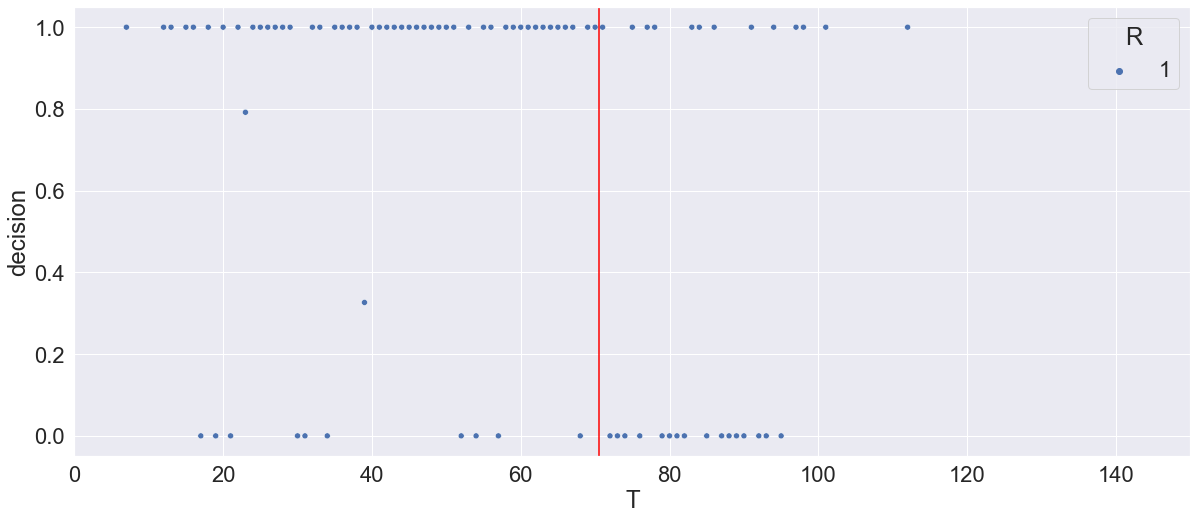

In [31]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


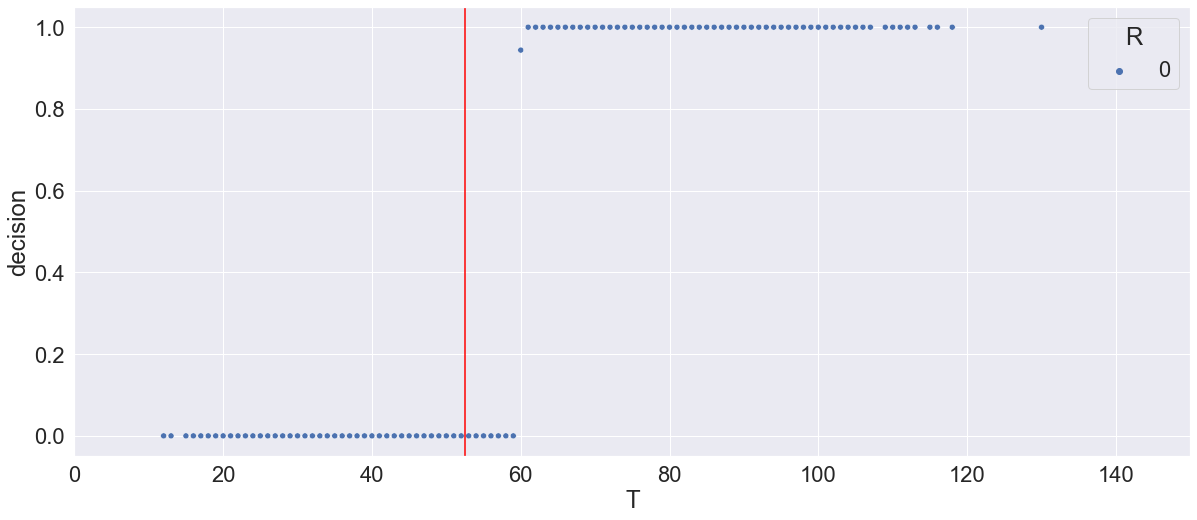

In [32]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [33]:
admit_decisions[admit_decisions['decision']==0][['R_x','Y']].groupby(['R_x']).mean()

,Y
R_x,
0,0.379451
1,0.409815


In [34]:
str(FRAC_minority_POLICY),str(SUM_BP_POLICY)

('0.5556530652803978', '25032.000000000007')

In [35]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

0.5006400000000002

In [36]:
str(FRAC_minority_POLICY),str(SUM_BP_POLICY)

('0.5556530652803978', '25032.000000000007')

In [37]:
admit_decisions[admit_decisions['decision']==1]['Y'].mean()

0.49911301262652613

In [38]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

32097.742933286765

In [39]:
(admit_decisions['decision'] * admit_decisions['Y']).sum()

25032.000000000007

In [40]:
admit_decisions[admit_decisions['decision']==1]['Y'].sum()

23915

In [41]:
(admit_decisions['decision'] * admit_decisions['Y']).sum()/(len(admit_decisions)*FRAC_ADMIT)

0.5006400000000002

In [42]:
(admit_decisions['decision'].sum())

50000.000000000015

In [43]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']


In [44]:
admit_decisions[admit_decisions['dec_binary']==0][['R_x','Y']].groupby(['R_x']).mean()

,Y
R_x,
0,0.379983
1,0.379816


In [45]:
admit_decisions['R_x'].value_counts()

0    66718
1    33282
Name: R_x, dtype: int64